In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch using ', device.type)

pytorch using  cuda


In [82]:
# hyperparameter

max_words = 5000
sentence_len = 20
pred_len = 3
train_len = sentence_len - pred_len

epochs = 10
batch_size = 2**10

max_samples = int(5e6)


## Data retrieval

In [83]:
with open('processed_texts.csv', 'r', encoding='UTF-8') as file:
    train_data = [line.strip('\n') for line in file]

# tokenize words in text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

# sentences as word sequences with max_words or words in text if less
sequences = tokenizer.texts_to_sequences(train_data)

# Flatten the list of lists to apply sliding window
text = [item for sublist in sequences for item in sublist]

In [84]:

# Sliding window to generate train data
seq = []
for i in range(len(text)-sentence_len):
    seq.append(text[i:i+sentence_len])

# reduce length of seq for performance reasons and of cause test_set
print('available samples: ', len(seq))
seq = seq[:max_samples]

# Reverse dictionary to decode tokenized sequences back to words
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# set data, label
X = []
y = []
for i in seq:
    X.append(i[:train_len])
    y.append(i[-pred_len:])

num_samples = len(y)

X = np.array(X)
y = np.array(y)

words_in_text = len(tokenizer.word_index)
vocab_size = words_in_text if words_in_text < max_words else max_words

print('Number of training sentences: ', len(train_data))
print('Number of training samples: ', num_samples)
print("vocab size:", vocab_size)

available samples:  4740340
Number of training sentences:  2477
Number of training samples:  4740340
vocab size: 5000


In [85]:

# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2)

# setting type for device
X_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor
y_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor

# create feature and targets tensor for train set.
torch_X_train = torch.from_numpy(X_train).type(X_type)
torch_y_train = torch.from_numpy(y_train).type(y_type)

# create feature and targets tensor for valid set.
torch_X_valid = torch.from_numpy(X_valid).type(X_type)
torch_y_valid = torch.from_numpy(y_valid).type(y_type)

# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
valid = torch.utils.data.TensorDataset(torch_X_valid, torch_y_valid)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)


print('batches: ', len(valid_loader))

batches:  926


In [86]:
print('{:.2f}MB per batch in device mem'.format(batch_size * X_train[0].size * 64 / 8 * 1e-6))

0.14MB per batch in device mem


## Model functions

In [79]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    correct = 0
    batch_losses = 0
    num_batches = len(data_loader) 
    
    for X_batch, y_batch in data_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch)
        loss = 0
        for i in range(pred_len):
            loss = loss + criterion(preds[:,i,:], y_batch[:,i])
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()

        batch_losses += loss.item()
        # Total correct predictions
        correct_in_batch = 0
        for i in range(pred_len): 
            predicted = torch.max(preds[:,i,:].data, 1)[1] 
            correct_in_batch += (predicted == y_batch[:,i]).sum()
        correct_in_batch /= pred_len
        correct += correct_in_batch
    
    # average loss and accuracies per epoch
    loss = batch_losses / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def test(model, criterion, data_loader):
    model.eval()
    correct = 0
    batch_losses = 0
    num_batches = len(data_loader) 

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch)
            loss = 0
            for i in range(preds.shape[1]):
                loss = loss + criterion(preds[:,i,:], y_batch[:,i])
            
            batch_losses += loss.item()
            # Total correct predictions
            correct_in_batch = 0
            for i in range(pred_len): 
                predicted = torch.max(preds[:,i,:].data, 1)[1] 
                correct_in_batch += (predicted == y_batch[:,i]).sum()
            correct_in_batch /= pred_len
            correct += correct_in_batch
    
    # average loss and accuracies per epoch
    loss = batch_losses  / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def fit(model, train_loader, valid_loader, optimizer, criterion, scheduler=None, save_model=True):
    print("fitting model...")
    
    train_eval = []
    valid_eval = []
    fit_start = time.time()

    #iteration 0 (only testing initial model)
    train_loss, train_accu = test(model, criterion, train_loader)
    train_eval.append( (train_loss, train_accu) )
    valid_loss, valid_accu = test(model, criterion, valid_loader)
    valid_eval.append( (valid_loss, valid_accu) )
    print('Epoch: 0')
    print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
    print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    for epoch in range(epochs):
        epoch_start = time.time()

        train_loss, train_accu = train(model, criterion, optimizer, train_loader)
        train_eval.append( (train_loss, train_accu) )
        
        valid_loss, valid_accu = test(model, criterion, valid_loader)
        valid_eval.append( (valid_loss, valid_accu) )

        if(scheduler != None): scheduler.step()  # update learning rate

        print('Epoch: {},    duration: {:.2f}sec'.format(epoch + 1, time.time() - epoch_start))
        print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
        print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    d = time.gmtime(time.time() - fit_start)
    print('duration of fitting: {:2d}h {:2d}min {:2d}sec'.format(d.tm_hour, d.tm_min, d.tm_sec))

    # save model
    if save_model:
        path = './models/' + model.__class__.__name__ + '.pth'
        torch.save(model, path)

    return np.array(train_eval), np.array(valid_eval)


def plot_eval(train_eval, valid_eval):

    train_losses = train_eval[:, 0]
    train_accus  = train_eval[:, 1]
    valid_losses = valid_eval[:, 0]
    valid_accus  = valid_eval[:, 1]
    min_loss_idx = np.argmin(valid_losses)
    max_accu_idx = np.argmax(valid_accus)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="validation")
    plt.scatter(min_loss_idx, valid_losses[min_loss_idx], c='r', label="minimum")
    plt.title("evaluation of losses")
    plt.xlabel("epochs")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_accus, label="train")
    plt.plot(valid_accus, label="validation")
    plt.scatter(max_accu_idx, valid_accus[max_accu_idx], c='r', label="maximum")
    plt.title("evaluation of accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()


def save_eval_data(model, train_eval, valid_eval):
    data = np.array([train_eval, valid_eval])
    path = './models/evalutation_' + model.__class__.__name__
    numpy.savetxt(path, data, delimiter=",")

## Models

In [71]:
learning_rate = 0.02
m1_embedding_dim=50
m1_lstm_hidden = 100
m1_dense_features = 100
m1_dropout = 0.3

class Model1(nn.Module):
    
    def __init__(self):
        super(Model1, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m1_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.LSTM(input_size=m1_embedding_dim, 
                            hidden_size=m1_lstm_hidden, 
                            num_layers=2)
        self.dense1 = nn.Linear(in_features=m1_lstm_hidden, 
                                out_features=m1_dense_features)
        self.dense2 = nn.Linear(in_features=m1_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-pred_len:,:]  # get pred_len last steps of output
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model1 = Model1().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

model1

Model1(
  (embed): Embedding(5001, 50, padding_idx=18)
  (rnn): LSTM(50, 100, num_layers=2)
  (dense1): Linear(in_features=100, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=5000, bias=True)
)

In [89]:
learning_rate = 0.02
m2_embedding_dim=50
m2_gru_hidden = 100
m2_dense_features = 100
m2_dropout = 0.3

class Model2(nn.Module):
    
    def __init__(self):
        super(Model2, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m2_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.GRU(input_size=m1_embedding_dim, 
                            hidden_size=m2_gru_hidden, 
                            num_layers=3)
        self.dense1 = nn.Linear(in_features=m2_gru_hidden, 
                                out_features=m2_dense_features)
        self.dense2 = nn.Linear(in_features=m2_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-pred_len:,:]  # get last steps of output
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model2 = Model2().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

model2

Model2(
  (embed): Embedding(5001, 50, padding_idx=17)
  (rnn): GRU(50, 100, num_layers=3)
  (dense1): Linear(in_features=100, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=5000, bias=True)
)

In [90]:
learning_rate = 0.06
m3_embedding_dim=50
m3_lstm_hidden = 40
m3_lstm_dropout = 0.1
m3_dense_features = 100
m3_dropout = 0.3

class Model3(nn.Module):
    
    def __init__(self):
        super(Model3, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m3_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.LSTM(input_size=m3_embedding_dim, 
                            hidden_size=m3_lstm_hidden, 
                            num_layers=3,
                            dropout=m3_lstm_dropout)
        self.dense1 = nn.Linear(in_features=m3_lstm_hidden, 
                                out_features=m3_dense_features)
        self.dense2 = nn.Linear(in_features=m3_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-pred_len:,:]  # get last steps of output
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model3 = Model3().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
scheduler3 = None  # optim.lr_scheduler.MultiplicativeLR(optimizer3, lambda epoch: 0.95)

model3

Model3(
  (embed): Embedding(5001, 50, padding_idx=17)
  (rnn): LSTM(50, 40, num_layers=3, dropout=0.1)
  (dense1): Linear(in_features=40, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=5000, bias=True)
)

## fitting & evaluation

In [69]:
criterion = nn.CrossEntropyLoss().to(device) 

In [91]:
eval_train1, eval_valid1 = fit(model1, train_loader, valid_loader, optimizer1, criterion, save_model=True)
plot_eval(eval_train1, eval_valid1)

fitting model...
Epoch: 0
Train:        Loss: 25.570914   Accuracy: 0.00%  
Validation:   Loss: 25.570851   Accuracy: 0.00%



TypeError: 'TensorDataset' object is not callable

In [14]:
# eval_train2, eval_valid2 = fit(model2, train_loader, valid_loader, optimizer2, criterion)
# plot_eval(eval_train2, eval_valid2)

fitting model...
Epoch: 0
Train:        Loss: 8.520313   Accuracy: 0.02%  
Validation:   Loss: 8.520043   Accuracy: 0.02%

Epoch: 1,    duration: 563.14sec
Train:        Loss: 5.879363   Accuracy: 7.94%  
Validation:   Loss: 5.701840   Accuracy: 9.40%

Epoch: 2,    duration: 572.05sec
Train:        Loss: 5.702647   Accuracy: 9.76%  
Validation:   Loss: 5.658384   Accuracy: 10.24%

Epoch: 3,    duration: 565.53sec
Train:        Loss: 5.683976   Accuracy: 9.96%  
Validation:   Loss: 5.650704   Accuracy: 10.25%

Epoch: 4,    duration: 593.09sec
Train:        Loss: 5.680744   Accuracy: 9.94%  
Validation:   Loss: 5.649261   Accuracy: 10.14%

Epoch: 5,    duration: 559.01sec
Train:        Loss: 5.679112   Accuracy: 9.95%  
Validation:   Loss: 5.651936   Accuracy: 10.21%

Epoch: 6,    duration: 541.84sec
Train:        Loss: 5.684149   Accuracy: 9.91%  
Validation:   Loss: 5.651196   Accuracy: 10.37%

Epoch: 7,    duration: 542.08sec
Train:        Loss: 5.684147   Accuracy: 9.89%  
Validation

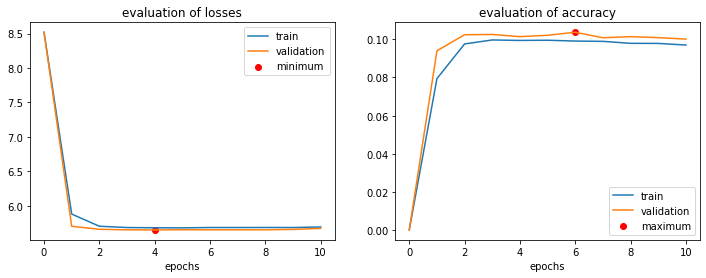

In [26]:
eval_train3, eval_valid3 = fit(model3, train_loader, valid_loader, optimizer3, criterion, scheduler3)
plot_eval(eval_train3, eval_valid3)

## Generating sentences

In [27]:
def gen(model, sentence, iterations=10):

    sequences = tokenizer.texts_to_sequences([sentence])
    seq = [item for sublist in sequences for item in sublist] # tokenized words
    if(len(seq) < train_len): return -1
    
    for i in range(iterations):
        iput = np.array(seq[-19:])
        iput = np.vstack(iput).T
        iput = torch.from_numpy(iput).type(X_type)

        # oput = F.log_softmax( model(iput) )  # prob dist
        oput = model(iput)
        
        oput = oput.cpu().detach().numpy()[0]
        # print(np.average(oput))
        oput = np.argmax(oput) # one-hot to long
        seq.append(oput)

    pred_sen = ''
    for tk in seq:
        pred_sen += reverse_word_map[tk] + ' '
    return pred_sen


In [28]:
sen = "Calls on Member States, in the light of the growing risks which the European Union is running in terms of energy security"
print(gen(model1, sen))
print(gen(model3, sen))

calls on member states in the light of the growing risks which the european union is running in terms of energy security jesus healthy exciting backwards backwards cocaine backwards japanese lanes dinosaurs 
calls on member states in the light of the growing risks which the european union is running in terms of energy security and the of the the of the of the of 
